# Developing an AI application to recognise flower species
# Part 3

## Introduction

In an [earlier project](https://github.com/pranath/flower_recognition/blob/master/image_classifier.ipynb) I developed a deep learning image classifier to classify images of 102 categories of flower species from the Oxford visual geometry group. The deep learning library used for that project was PyTorch, and the best result achieved in that project was a test accuracy of 73%.

In [Part 2](https://github.com/pranath/flower_recognition/blob/master/image-classifier-v2.ipynb) of this project I looked at the same dataset, but used a new deep learning library called [fastai](https://www.fast.ai) (which is based on PyTorch) to develop an image classifier, which had an improved test accuracy of 93%.

In this project Part 3 I will:

- Extract the dataset in a different way (using external url)
- Develop a model based on the best architecture of part 2 (Resnet-50)
- Experiment with manual convolutions on images
- Explore heatmaps which allow us to look inside the trained model to better understand what parts of an image it regards as most important for predicting the flower type

In this project the main objective is not to train the most optimal model per se, but rather train a sufficiently good model so that we can then use it to explore how convolutions work & help the model predict.

## Import libraries & config

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks.hooks import *
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [0]:
# Set batch size
bs = 64

In [33]:
# Extract data using fastai's convenience urls
path = untar_data(URLs.FLOWERS);
path.ls()

[PosixPath('/root/.fastai/data/oxford-102-flowers/labels.csv'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/models'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/test'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/valid'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/test.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/valid.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/labels_test.csv'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/train.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/train')]

The dataset extracted via the URL is not in the most convenient form, where the training, validation & test sets are defined by entries in text files. We will process the data to convert it into a folder organised type structure which will be easier to work with.

In [0]:
# Define function to restructure data
def prepare_data(path):
    labels_path = path/'labels.csv'
    labels_test_path = path/'labels_test.csv'
    train_path = path/'train'
    test_path = path/'test'
    
    # Clean up after last run
    if labels_path.exists():
        os.remove(str(labels_path))
        print("Removed existing labels.csv")
    
    if labels_test_path.exists():
        os.remove(str(labels_test_path))
        print("Removed existing labels_test.csv")
        
    if train_path.exists():
        shutil.rmtree(path/'train')
        print("Removed existing train folder.")
        
    if test_path.exists():    
        shutil.rmtree(path/'test')
        print("Removed existing test folder.")
        
    # Do actual preparation
    for t in ['train','valid']:
        copy_files_make_csv(t, path, 'labels.csv')
        
    # Prepare the test folder
    copy_files_make_csv('test', path, 'labels_test.csv')

def copy_files_make_csv(t, p, csv_name):
    if t not in ['train', 'test', 'valid']:
        raise ValueError("Argument must be either 'train' or 'test'")
    labels_path = p / (t + '.txt')
    fastai_labels = p / csv_name
    
    with open(fastai_labels, 'a') as labels:
        with open(labels_path) as f:
            for line in f:
                    jpg_filename, category = line.strip('\n').split(' ')
                    jpg = jpg_filename[:4]
                    filename = jpg_filename[4:]
                    target_path = str(p) + '/' + t + '/' + filename

                    if not os.path.exists(os.path.dirname(target_path)):
                        os.makedirs(os.path.dirname(target_path))
                        print(f'Created new dir: {os.path.dirname(target_path)}')

                    src = str(p/jpg/filename)
                    dst = str(p/target_path)
                    
                    shutil.copy2(src, dst)
                    labels.write(t + '/' + filename + ',' + category + '\n')
                
    print(labels_path)

In [35]:
# Restructure data
prepare_data(path)

Removed existing labels.csv
Removed existing labels_test.csv
Removed existing train folder.
Removed existing test folder.
Created new dir: /root/.fastai/data/oxford-102-flowers/train
/root/.fastai/data/oxford-102-flowers/train.txt
/root/.fastai/data/oxford-102-flowers/valid.txt
Created new dir: /root/.fastai/data/oxford-102-flowers/test
/root/.fastai/data/oxford-102-flowers/test.txt


In [36]:
# View new structure
path.ls()

[PosixPath('/root/.fastai/data/oxford-102-flowers/labels.csv'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/models'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/test'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/valid'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/test.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/valid.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/labels_test.csv'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/train.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/train')]

In [37]:
# Define paths
path # where the required structure for `.from_csv`
path_test = path / 'test'
print(path, path_test)

/root/.fastai/data/oxford-102-flowers /root/.fastai/data/oxford-102-flowers/test


In [0]:
# Prepare to create databunch
tfms = get_transforms()
data = ImageDataBunch.from_csv(path, size=299, ds_tfms=tfms, bs=bs).normalize(imagenet_stats)

In [39]:
# Show sizes
len(data.train_ds) + len(data.valid_ds)

2039

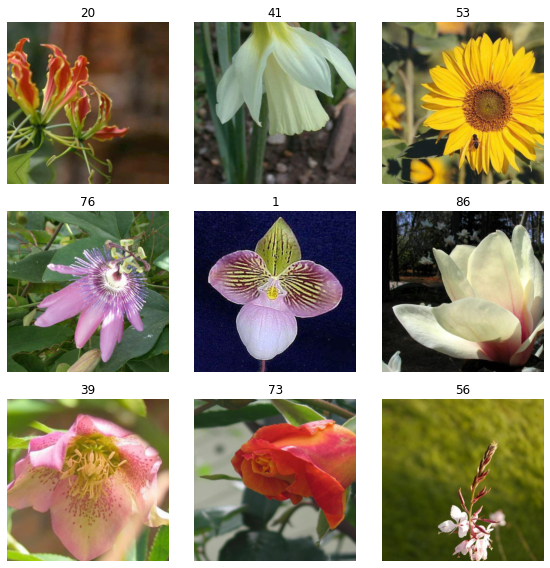

In [41]:
# View first few items of data
data.show_batch(rows=3, figsize=(8,8))

## Create and train model

So in Part 2 we discovered the Resnet-50 architecture did best, so we will use this now.

In [0]:
# Create model
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [44]:
# Train model
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,4.960819,1.998586,0.417690,00:39
1,2.671150,0.679221,0.179361,00:38
2,1.554710,0.570081,0.142506,00:38
3,0.971450,0.473581,0.125307,00:37
4,0.623712,0.414974,0.117936,00:37
5,0.414288,0.387847,0.098280,00:38
6,0.277562,0.374565,0.095823,00:38
7,0.198722,0.374738,0.090909,00:37


So after 8 epochs we have a reasonably good model with 91% accuracy which is in the same ball park of our best model from part 3 (93%). We will now used this trained model to explore how convolutional networks work.

## Manual Convolutions

In this part we will apply a manual convolution to one of the images to understand how this works. Normally in a modern convolutional network such as Resnet-50 the kernal functions used are values that are optimised via gradient descent, so in these networks the model actually creates its own kernals that it finds most useful for predicting the flower species. 

Another way to see this is that the model creates convolutional kernals that result in the lowest loss. What kind of kernals might these be? a key study on this by Zeiler & Fergus in 2013 ['Visualizing and Understanding Convolutional Networks'](https://arxiv.org/abs/1311.2901) helped us understand for the first time what these are. 

They found that early layers tended to have kernals that detected simple features link horizontal or diagonal lines, while later layers build on and combined these into more complex feature detectors for corners, eyes, and higher level features.

We will now explore how convolutions work on images by creating a kernal manually, in this case we construct a kernal that should detect bottom right edges in our images.

Category 18

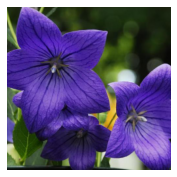

In [45]:
# Get an image
idx=0
x,y = data.valid_ds[idx]
# Show the flower
x.show()
# Show its category
data.valid_ds.y[idx]

Given our image has 3 colour channels, its a rank 3 tensor. So we can't use a simple 2d kernal - we need to create a rank 3 tensor kernal where each 2d kernal layer is optimised to respond to that corresponding colour channel. This really matters for helping the model predict. 

For example, if we wanted the model to detect green frogs - we probably want the kernal part concerned with the green channel to do something a bit different to the rest of the kernal. 

In this case we are just doing a simple manual example of a kernal operation, so to create our rank 3 tensor kernal all we will do is create a 2d kernal and simply copy the same values to each of the 3 layers using the PyTorch expand() method.

Note ultimately we create a rank 4 tensor for the kernal - why? the input is a rank 4 tensor i.e. batch x red x green x blue, so our kernal needs to be the same rank even tho thats of unit rank for 'batch'.

In [47]:
# Create our manual kernal which should detect bottom right corners in our flower image
manual_kernal = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6
# Print out the tensor/kernal
manual_kernal

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [48]:
# We have our rank 4 tensor kernal
manual_kernal.shape

torch.Size([1, 3, 3, 3])

In [49]:
# We extract one image to run our manual convolution on
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 299, 299])

So as mentioned PyTorch really expects mini-batches of images i.e. rank 4 tensors. The 1 image we have extracted is a rank 3 tensor - so we need to convert it to a rank 4 by adding a unit axes. To do this we will index into the tensor using 'None' which will create another unit axes.

In [50]:
# Add unit axes to create rank 4 tensor image
t[None].shape

torch.Size([1, 3, 299, 299])

Now we will apply our manual convolution to the image, and see what bottom-right corners it can detect in the flower image.

In [0]:
# Apply our manual kernal to image to create convolutions
edge = F.conv2d(t[None], manual_kernal)

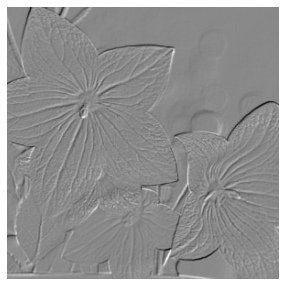

In [52]:
# Show convolutional activations
show_image(edge[0], figsize=(5,5));

## Explore heatmaps of convolutional activations

Our Resnet-50 goes through many convolutional layers, which eventually map onto 102 outputs corresponding to activations for the 102 flower categories in our dataset.

The final convolutional layer in our Resnet-50 has 2048 convoltional channels each of which is 10 x 10 pixels square. The process of mapping from this final layer to the output units is called **average pooling** were we take an average of all activations in each 10 x 10 layer, and map that to each of the 102 outputs. These final layers correspond to high level features for the flowers, such as 'how curved are the petals' etc. 

So if we are interested in understanding what the model considers important in the image for predicting different flower species, what we can instead do is rather than average pooling (which takes an average of each layer of 10 x 10) we can instead take the average activations for each pixel accross each of the channels. So we will end up with a 10 x 10 grid of average activations accross all channels (i.e. accross all high level features). 

If we do this, this might give us a good idea of what the model considers most important in the image for the prediction.

In [0]:
# Switch our model into eval mode (i.e. no training)
m = learn.model.eval();

In [0]:
# Get our first image
xb,_ = data.one_item(x)
# Before we put through model, we need to normalise the image and convert it into a 'mini-batch'
xb_im = Image(data.denorm(xb)[0])
# Then load it onto the GPU
xb = xb.cuda()

Pytorch gives us the ability to 'hook' into the model and grab its output. Fastai has created a convenience function hook_output() which if you pass it a model part, it will grab the output of that part of the model.

In [0]:
# Define function to capture model convolutional layer activations & gradients
def hooked_backward(cat=y):
    # Note: m[0] is the original convolutional part of the Resnet-50 model
    with hook_output(m[0]) as hook_a: # Hook activations of this model
        with hook_output(m[0], grad=True) as hook_g: # Hook gradients of this model
            preds = m(xb) # Put image through model to generate activations & predictions
            preds[0,int(cat)].backward() # Calculate gradients of model
    return hook_a,hook_g # Return captured model hook activations and gradients

In [0]:
# Capture model convolutional layer activations & gradients
hook_a,hook_g = hooked_backward()

In [58]:
# Extract model activations from 'stored' and put onto cpu
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 10, 10])

This is the final convolutional block of 2048 channels each channel 10x10. Lets now calculate the mean activations for each of these 10x10 pixels accross all 2048 channels.

In [59]:
# Calculate mean activations accross axis 0
avg_acts = acts.mean(0)
# Show size
avg_acts.shape

torch.Size([10, 10])

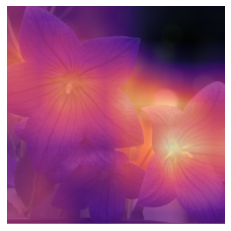

In [66]:
# Define function to plot heatmap of activations over image
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.8, extent=(0,299,299,0),
              interpolation='bilinear', cmap='magma');
# Show flower image together with mean activations
show_heatmap(avg_acts)

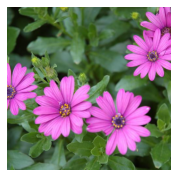

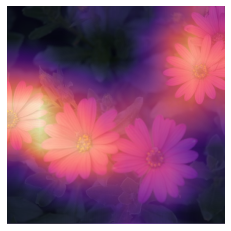

In [88]:
# Image 2
idx=1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]
# Before we put through model, we need to normalise the image and convert it into a 'mini-batch' then load onto GPU
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
# Capture model convolutional layer activations & gradients
hook_a,hook_g = hooked_backward()
# Extract model activations from 'stored' and put onto cpu
acts  = hook_a.stored[0].cpu()
acts.shape
# Calculate mean activations accross axis 0
avg_acts = acts.mean(0)
avg_acts.shape
# Show flower image together with mean activations
show_heatmap(avg_acts)

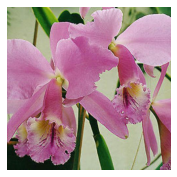

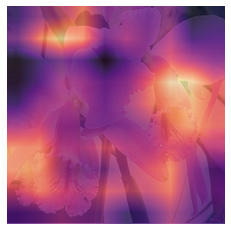

In [89]:
# Image 3
idx=2
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]
# Before we put through model, we need to normalise the image and convert it into a 'mini-batch' then load onto GPU
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
# Capture model convolutional layer activations & gradients
hook_a,hook_g = hooked_backward()
# Extract model activations from 'stored' and put onto cpu
acts  = hook_a.stored[0].cpu()
acts.shape
# Calculate mean activations accross axis 0
avg_acts = acts.mean(0)
avg_acts.shape
# Show flower image together with mean activations
show_heatmap(avg_acts)

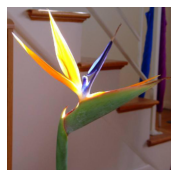

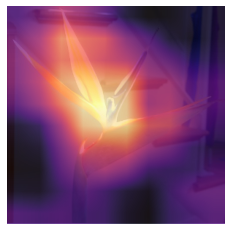

In [90]:
# Image 4
idx=3
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]
# Before we put through model, we need to normalise the image and convert it into a 'mini-batch' then load onto GPU
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
# Capture model convolutional layer activations & gradients
hook_a,hook_g = hooked_backward()
# Extract model activations from 'stored' and put onto cpu
acts  = hook_a.stored[0].cpu()
acts.shape
# Calculate mean activations accross axis 0
avg_acts = acts.mean(0)
avg_acts.shape
# Show flower image together with mean activations
show_heatmap(avg_acts)

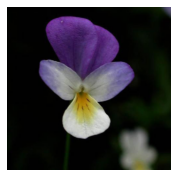

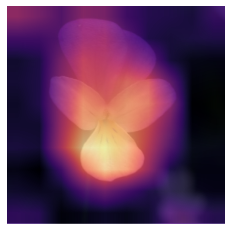

In [91]:
# Image 5
idx=4
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]
# Before we put through model, we need to normalise the image and convert it into a 'mini-batch' then load onto GPU
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
# Capture model convolutional layer activations & gradients
hook_a,hook_g = hooked_backward()
# Extract model activations from 'stored' and put onto cpu
acts  = hook_a.stored[0].cpu()
acts.shape
# Calculate mean activations accross axis 0
avg_acts = acts.mean(0)
avg_acts.shape
# Show flower image together with mean activations
show_heatmap(avg_acts)

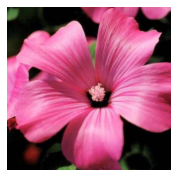

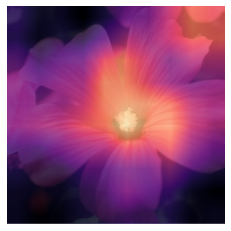

In [93]:
# Image 6
idx=5
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]
# Before we put through model, we need to normalise the image and convert it into a 'mini-batch' then load onto GPU
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
# Capture model convolutional layer activations & gradients
hook_a,hook_g = hooked_backward()
# Extract model activations from 'stored' and put onto cpu
acts  = hook_a.stored[0].cpu()
acts.shape
# Calculate mean activations accross axis 0
avg_acts = acts.mean(0)
avg_acts.shape
# Show flower image together with mean activations
show_heatmap(avg_acts)

## Conclusion

In this project we explored how convolutions work in this image classifier. In particular we explored how basic convolutions work, as well as looking at how final layer convolutions can be examined (using their activations) to gain a better understanding of what the model considers important in the flower image for making its predictions.